# RAG Pipeline over watched foler to be embedded using Chroma in the  Working Directory.

This notebook lets you:
1. **Upload a `.txt` file manually** (Colab or local Jupyter).
2. **Chunk & embed** the text with `sentence-transformers`.
3. **Store** vectors in a **Chroma** DB saved to `./chroma` (working directory).
4. **Ask questions**: a simple **RAG** flow retrieves top snippets and answers via:
   - **OpenAI** (if `OPENAI_API_KEY` is set), or
   - **Local Transformers** fallback (`google/flan-t5-base`) if no OpenAI key.
   
> Works on **Colab** and **Windows/macOS** Jupyter. No `.env`/dotenv needed.

In [1]:
# ## 0) Install dependencies
import sys
print(sys.version)

# Core libs
!pip -q install langchain langchain-community chromadb sentence-transformers

# For optional local LLM fallback
!pip -q install transformers accelerate

3.10.19 (main, Oct 21 2025, 16:37:10) [Clang 20.1.8 ]


In [2]:
from pathlib import Path
from dotenv import load_dotenv
#Loading API key
env_path = Path("/Volumes/Untitled/Lessons_By_Week/Project_Rag/Final_Codes/ATT81022.env")
load_dotenv(dotenv_path=env_path)

# Now your existing code works:
# OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "").strip()

True

In [3]:

import os
from pathlib import Path

# ath where Chroma (vector DB) will be persisted ---
CHROMA_DIR = "./chroma"   # working directory
COLLECTION = "uploaded_text"

# --- Optional: OpenAI ---
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "").strip()
USE_OPENAI = bool(OPENAI_API_KEY)
if USE_OPENAI:
    print("✅ Using OpenAI for generation.")
else:
    print("ℹ️ OPENAI_API_KEY not set — will use local Transformers fallback.")

Path(CHROMA_DIR).mkdir(parents=True, exist_ok=True)
print("CHROMA_DIR =", Path(CHROMA_DIR).resolve())
print("COLLECTION  =", COLLECTION)

✅ Using OpenAI for generation.
CHROMA_DIR = /Volumes/Untitled/Lessons_By_Week/Project_Rag/Final_Codes/chroma
COLLECTION  = uploaded_text


In [4]:
## 3) Read & clean the text
uploaded_path = "/Volumes/Untitled/Youtube_QA_Rag_System/Working_Pipelines/text/RAG_TEXT.txt"
from pathlib import Path

p = Path(uploaded_path).expanduser()
assert p.exists(), f"File not found: {p}"

text = p.read_text(encoding="utf-8", errors="ignore")
print(f"Loaded {len(text):,} characters from:", p.resolve())

Loaded 10,135 characters from: /Volumes/Untitled/Youtube_QA_Rag_System/Working_Pipelines/text/RAG_TEXT.txt


In [5]:
from langchain.retrievers.multi_query import MultiQueryRetriever

/opt/anaconda3/envs/Rag_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- deps ---
from pathlib import Path
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings  # requires sentence-transformers
# from langchain_openai import OpenAIEmbeddings  # <- alt if you prefer OpenAI

# --- embeddings ---
# HF option (offline-friendly). You can swap to any sentence-transformers model you have:
emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# emb = OpenAIEmbeddings()  # if using OpenAI

# --- sample docs (replace with your real text) ---
raw_texts = [
    "Chitty is our YouTube RAG chatbot.",
    "We store vectors in Chroma for fast similarity search.",
    "Time-weighted retrieval boosts recent docs."
]
splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
docs = [Document(page_content=t) for t in raw_texts]
docs = splitter.split_documents(docs)

# --- vector store (Chroma) ---
persist_dir = "./chroma_db"
Path(persist_dir).mkdir(parents=True, exist_ok=True)
vectorstore = Chroma.from_documents(documents=docs, embedding=emb, persist_directory=persist_dir)
# If you need to append later, you can do: vectorstore.add_documents(new_docs)

# --- retriever (this is what your assertion expects) ---
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})


In [6]:
# pip install -U langchain-openai
from langchain_openai import ChatOpenAI

# Make sure OPENAI_API_KEY is in your environment
# (e.g., export OPENAI_API_KEY=sk-... in your shell before starting the notebook)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [7]:
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.tools.retriever import create_retriever_tool

In [8]:
# === Multi-Query Agent (LangChain agent + tool) ===
# Drop-in cell: requires langchain>=0.2, langchain-openai (or your existing llm)

from typing import Any
import os

# --- CORRECTED IMPORTS ---
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.tools.retriever import create_retriever_tool  # <-- This is the corrected line
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.retrievers.multi_query import MultiQueryRetriever
# --- END OF FIX ---


# USE this:
from langchain_core.documents import Document

from typing import List
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
# Either of these works depending on your setup:
from langchain_community.embeddings import HuggingFaceEmbeddings
# or: from langchain_huggingface import HuggingFaceEmbeddings

# --- sanity checks (expects you already created these) ---
assert "retriever" in globals(), "Define `retriever = vectorstore.as_retriever(...)` first."
assert "llm" in globals(), "Define your `llm` (e.g., ChatOpenAI(...)) first."

# 2) Wrap your retriever with MultiQuery
#    include_original=True so the original query is part of the mix.
mq_retriever = MultiQueryRetriever.from_llm(
    retriever=retriever,
    llm=llm,
    include_original=True,
)

# 3) Turn it into a Tool the agent can call
mq_tool = create_retriever_tool(
    mq_retriever,
    name="multi_query_search",
    description=(
        "Search the local knowledge base using multiple reformulations of the user question. "
        "Use this to gather evidence before answering. Returns the most relevant chunks with sources."
    ),
)

tools = [mq_tool]

# 4) Agent prompt (tool-calling)
system_msg = (
    "You are a precise research agent. Always call tools when the user asks a question "
    "that may require context. Combine results, cite briefly like [source]. If not found, say so."
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_msg),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

# 5) Build agent + executor
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,                  # set True to see the reasoning/tool calls
    handle_parsing_errors=True,
    return_intermediate_steps=True, # lets you inspect tool traces
)

def ask_multi_agent(question: str, chat_history: list[dict[str, Any]] | None = None):
    """
    Invoke the multi-query agent.
    chat_history: optional list of {'role': 'user'|'assistant', 'content': str}
    """
    chat_history = chat_history or []
    result = agent_executor.invoke(
        {
            "input": question,
            "chat_history": chat_history,
        }
    )
    # result keys: 'output' (final answer), 'intermediate_steps' (tool calls/returns)
    return result

# --- Example use ---
# reply = ask_multi_agent("Give a concise summary of the core ideas in the corpus and cite.")
# print(reply["output"])
# print("\nTool trace:", reply["intermediate_steps"])
# === End drop-in ===

AssertionError: Define `retriever = vectorstore.as_retriever(...)` first.

In [ ]:
# === Multi-Query Agent (LangChain agent + tool) ===
# Drop-in cell: requires langchain>=0.2, langchain-openai (or your existing llm)

from typing import Any
import os


# USE this:
from langchain_core.documents import Document

from typing import List
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
# Either of these works depending on your setup:
from langchain_community.embeddings import HuggingFaceEmbeddings
# or: from langchain_huggingface import HuggingFaceEmbeddings

# --- sanity checks (expects you already created these) ---
assert "retriever" in globals(), "Define `retriever = vectorstore.as_retriever(...)` first."
assert "llm" in globals(), "Define your `llm` (e.g., ChatOpenAI(...)) first."

# 2) Wrap your retriever with MultiQuery
#    include_original=True so the original query is part of the mix.
mq_retriever = MultiQueryRetriever.from_llm(
    retriever=retriever,
    llm=llm,
    include_original=True,
)

# 3) Turn it into a Tool the agent can call
mq_tool = create_retriever_tool(
    mq_retriever,
    name="multi_query_search",
    description=(
        "Search the local knowledge base using multiple reformulations of the user question. "
        "Use this to gather evidence before answering. Returns the most relevant chunks with sources."
    ),
)

tools = [mq_tool]

# 4) Agent prompt (tool-calling)
system_msg = (
    "You are a precise research agent. Always call tools when the user asks a question "
    "that may require context. Combine results, cite briefly like [source]. If not found, say so."
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_msg),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

# 5) Build agent + executor
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,                  # set True to see the reasoning/tool calls
    handle_parsing_errors=True,
    return_intermediate_steps=True, # lets you inspect tool traces
)

def ask_multi_agent(question: str, chat_history: list[dict[str, Any]] | None = None):
    """
    Invoke the multi-query agent.
    chat_history: optional list of {'role': 'user'|'assistant', 'content': str}
    """
    chat_history = chat_history or []
    result = agent_executor.invoke(
        {
            "input": question,
            "chat_history": chat_history,
        }
    )
    # result keys: 'output' (final answer), 'intermediate_steps' (tool calls/returns)
    return result

# --- Example use ---
# reply = ask_multi_agent("Give a concise summary of the core ideas in the corpus and cite.")
# print(reply["output"])
# print("\nTool trace:", reply["intermediate_steps"])
# === End drop-in ===


In [9]:
## 4) Chunk → Embed → Persist to Chroma

# --- Chunk → Embed → Persist to Chroma (version-safe) ---

from pathlib import Path
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_community.embeddings import HuggingFaceEmbeddings

# 1) Chunk the text
splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50,
    separators=["\n\n", "\n", ". ", " ", ""],
)
docs = [Document(page_content=c, metadata={"source": str(p.name)}) 
        for c in splitter.split_text(text)]
print(f"Chunks created: {len(docs)}")

# 2) Embedding function (no manual embedding arrays)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    encode_kwargs={"normalize_embeddings": True},
)

# 3) Create (or re-open) the Chroma collection in the working dir
#    NOTE: We pass `embedding_function=embeddings` so vectorstore handles embeddings internally.
vs = Chroma(
    collection_name=COLLECTION,
    persist_directory=CHROMA_DIR,
    embedding_function=embeddings,
)

# 4) (Optional) Clear previous contents of this collection
#    Easiest cross-version reset: use a fresh collection name, or delete the folder manually.
#    If you really want programmatic clearing, uncomment:
# try:
#     # Recreate an empty collection (requires chromadb>=0.4 with delete support)
#     from chromadb import PersistentClient
#     client = PersistentClient(path=CHROMA_DIR)
#     try:
#         client.delete_collection(COLLECTION)
#     except Exception:
#         pass
#     vs = Chroma(
#         collection_name=COLLECTION,
#         persist_directory=CHROMA_DIR,
#         embedding_function=embeddings,
#     )
# except Exception:
#     pass

# 5) Add docs (embeddings computed under the hood)
vs.add_documents(docs)

# 6) Persist if available (older langchain-Chroma exposes .persist(); newer chromadb persists automatically)
try:
    vs.persist()  # no-op on some versions; safe to call if present
except Exception:
    pass

print("✅ Stored in Chroma at:", Path(CHROMA_DIR).resolve())



Chunks created: 55


/var/folders/59/_rmmbn7d6kx3y2yg0wqg8ghc0000gn/T/ipykernel_64707/1611531965.py:22: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/var/folders/59/_rmmbn7d6kx3y2yg0wqg8ghc0000gn/T/ipykernel_64707/1611531965.py:29: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vs = Chroma(


✅ Stored in Chroma at: /Volumes/Untitled/Lessons_By_Week/Project_Rag/Final_Codes/chroma


/var/folders/59/_rmmbn7d6kx3y2yg0wqg8ghc0000gn/T/ipykernel_64707/1611531965.py:59: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vs.persist()  # no-op on some versions; safe to call if present


In [10]:
# ADD THIS LINE TO THE END OF CELL 10:
retriever = vs.as_retriever(search_kwargs={"k": 5})

print("\n✅ Created 'retriever' variable pointing to RAG_TEXT.txt")


✅ Created 'retriever' variable pointing to RAG_TEXT.txt


Analyzing similarity between first 10 paragraphs...

📊 Similarity Matrix (first 5x5):
Rows/Columns represent paragraph indices
[[1.    0.787 0.654 0.572 0.371]
 [0.787 1.    0.715 0.61  0.468]
 [0.654 0.715 1.    0.572 0.505]
 [0.572 0.61  0.572 1.    0.523]
 [0.371 0.468 0.505 0.523 1.   ]]

🔗 Most similar paragraphs: 0 & 1
   Similarity score: 0.787
   Para 0: Exploring Europe: A Comprehensive Guide for Travelers...
   Para 1: Europe, a continent woven with centuries of history, art, and natural beauty, remains one of the wor...

🚫 Least similar paragraphs: 5 & 6
   Similarity score: 0.289
   Para 5: The Netherlands delights with its canals, tulip fields, and cycling culture. Amsterdam’s Rijksmuseum...
   Para 6: Switzerland, perched among the Alps, tempts lovers of nature and precision alike. Lucerne, Interlake...


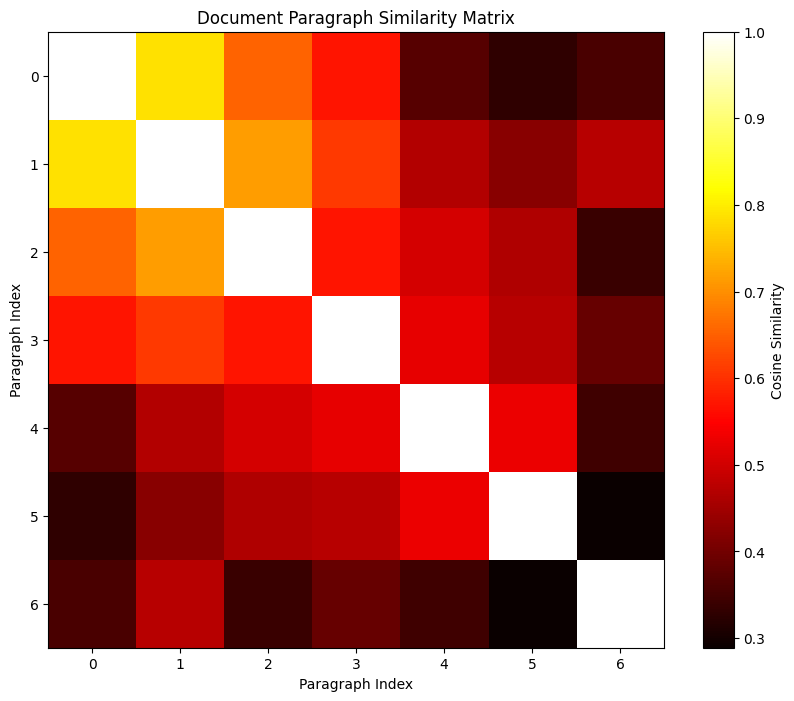

In [11]:
# Pre-chunking similarity analysis ---

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

def analyze_document_similarity(text, sample_size=10, window_size=3):
    """
    Analyze similarity between different parts of the document before chunking
    """
    # Split into paragraphs/sections first
    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
    paragraphs = paragraphs[:sample_size]  # Analyze first N paragraphs
    
    print(f"Analyzing similarity between first {len(paragraphs)} paragraphs...")
    
    # Embed each paragraph
    paragraph_embeddings = []
    valid_paragraphs = []
    
    for i, para in enumerate(paragraphs):
        if len(para) > 50:  # Only embed meaningful paragraphs
            embedding = embeddings.embed_query(para)
            paragraph_embeddings.append(embedding)
            valid_paragraphs.append((i, para[:100] + "..."))  # Store preview
    
    if len(paragraph_embeddings) < 2:
        print("Not enough meaningful paragraphs for similarity analysis")
        return
    
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(paragraph_embeddings)
    
    print("\n📊 Similarity Matrix (first 5x5):")
    print("Rows/Columns represent paragraph indices")
    print(np.round(similarity_matrix[:5, :5], 3))
    
    # Find most similar and least similar pairs
    n = len(similarity_matrix)
    most_similar = (0, 1, similarity_matrix[0, 1])
    least_similar = (0, 1, similarity_matrix[0, 1])
    
    for i in range(n):
        for j in range(i+1, n):
            sim = similarity_matrix[i, j]
            if sim > most_similar[2]:
                most_similar = (i, j, sim)
            if sim < least_similar[2]:
                least_similar = (i, j, sim)
    
    print(f"\n🔗 Most similar paragraphs: {most_similar[0]} & {most_similar[1]}")
    print(f"   Similarity score: {most_similar[2]:.3f}")
    print(f"   Para {most_similar[0]}: {valid_paragraphs[most_similar[0]][1]}")
    print(f"   Para {most_similar[1]}: {valid_paragraphs[most_similar[1]][1]}")
    
    print(f"\n🚫 Least similar paragraphs: {least_similar[0]} & {least_similar[1]}")
    print(f"   Similarity score: {least_similar[2]:.3f}")
    print(f"   Para {least_similar[0]}: {valid_paragraphs[least_similar[0]][1]}")
    print(f"   Para {least_similar[1]}: {valid_paragraphs[least_similar[1]][1]}")
    
    # Visualize similarity matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Paragraph Similarity Matrix')
    plt.xlabel('Paragraph Index')
    plt.ylabel('Paragraph Index')
    plt.show()
    
    return similarity_matrix, valid_paragraphs

# Run the analysis
similarity_matrix, paragraphs_info = analyze_document_similarity(text)

In [12]:
#The below helps with embeddings in, so no global NameError returns: similarity_matrix, kept_indices, clusters, and paragraphs_info includes duplicate pruning + cluster detection from the matr

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def analyze_and_cluster(
    text: str,
    embeddings,
    sample_size: int = 10,
    min_len: int = 50,
    dup_threshold: float = 0.85,     # ≥ this => near-duplicate
    cluster_threshold: float = 0.70, # median pairwise ≥ this => same cluster
    plot: bool = True,
):
    # 1) split -> pick first N meaningful paragraphs
    paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]
    paragraphs = paragraphs[:sample_size]
    picked = [(i, p) for i, p in enumerate(paragraphs) if len(p) >= min_len]
    if len(picked) < 2:
        raise ValueError("Need at least 2 meaningful paragraphs.")

    # 2) embeddings
    embs = np.array([embeddings.embed_query(p) for _, p in picked], dtype="float32")
    sim = cosine_similarity(embs)

    # 3) prune duplicates (greedy keep-1-per-dup-clique)
    keep = []
    skipped = set()
    for i in range(len(picked)):
        if i in skipped: 
            continue
        keep.append(i)
        dup_idx = np.where(sim[i] >= dup_threshold)[0]
        for j in dup_idx:
            if j != i:
                skipped.add(j)

    embs_kept = embs[keep]
    sim_kept  = cosine_similarity(embs_kept)

    # 4) cluster kept paragraphs (simple agglomeration via threshold on average sim)
    #    Build clusters by growing sets where the average similarity to the cluster ≥ cluster_threshold
    clusters = []
    unused = set(range(len(keep)))
    while unused:
        seed = unused.pop()
        cluster = [seed]
        grown = True
        while grown:
            grown = False
            for cand in list(unused):
                avg_sim = np.mean([sim_kept[cand, m] for m in cluster])
                if avg_sim >= cluster_threshold:
                    cluster.append(cand)
                    unused.remove(cand)
                    grown = True
        clusters.append(sorted(cluster))

    # 5) pretty previews
    paragraphs_info = [(picked[i][0], picked[i][1][:100] + ("..." if len(picked[i][1])>100 else ""))
                       for i in range(len(picked))]

    # 6) small console report
    print(f"Analyzing similarity between first {len(paragraphs)} paragraphs...")
    print("\n📊 Similarity Matrix (kept first 5x5):")
    print(np.round(sim_kept[:5, :5], 3))
    print("\n🧩 Clusters (indices refer to kept paragraphs):")
    for cidx, c in enumerate(clusters):
        print(f"  Cluster {cidx}: {c} -> doc paras {[picked[i][0] for i in c]}")

    # 7) optional plot
    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,8))
        plt.imshow(sim_kept, cmap="hot", interpolation="nearest")
        plt.colorbar(label="Cosine Similarity")
        plt.title("Document Paragraph Similarity Matrix (deduped)")
        plt.xlabel("Paragraph Index (kept)")
        plt.ylabel("Paragraph Index (kept)")
        plt.show()

    # return everything you need for chunking + metadata
    kept_indices = [picked[i][0] for i in keep]  # original doc paragraph indices kept
    return sim_kept, kept_indices, clusters, paragraphs_info, embs_kept


In [13]:

from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Reopen collection (simulates separate session)
vs = Chroma(collection_name=COLLECTION, persist_directory=CHROMA_DIR)

retriever = vs.as_retriever(search_kwargs={"k": 5})

def format_docs(docs):
    out = []
    for i, d in enumerate(docs):
        src = d.metadata.get("source", "")
        out.append(f"[{i}] {d.page_content}\n(source: {src})")
    return "\n\n".join(out)

SYSTEM_PROMPT = (
    "You are a helpful assistant. Answer the question **only** from the provided context.however you can give general friend conversations "
    "If the answer isn't present, say: 'I don't see that in the file.'"
      "store the last 2 questions for retreval '"
     "give full context to make the user understand '"
)

prompt = ChatPromptTemplate.from_messages([
    ("system", "{system}"),
    ("human", "Question: {question}\n\nContext:\n{context}\n\nAnswer succinctly:"),
])

# --- Choose generator ---
generator = None
if USE_OPENAI:
    from langchain_openai import ChatOpenAI
    generator = ChatOpenAI(model="gpt-4o-mini", temperature=0)
else:
    # Local Transformers text2text generation via HF pipeline
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

    model_id = "google/flan-t5-base"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
    hf_pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

    class HFText2TextLLM:
        def __call__(self, prompt_text: str) -> str:
            out = hf_pipe(prompt_text, max_new_tokens=256, truncation=True)
            return out[0]["generated_text"]

    # Wrap prompt execution manually when using local model
    generator = HFText2TextLLM()

# Build chain (LangChain-style if OpenAI; manual if local HF)
if USE_OPENAI:
    chain = (
        RunnableParallel({
            "context": (retriever | format_docs),
            "question": RunnablePassthrough(),
            "system": (lambda _: SYSTEM_PROMPT),
        })
        | prompt
        | generator
        | StrOutputParser()
    )
    print("✅ RAG chain (OpenAI) is ready.")
else:
    # We'll emulate the same behavior for the local model in a function
    def answer_local(question: str) -> str:
        ctx = format_docs(retriever.get_relevant_documents(question))
        full_prompt = (
            f"{SYSTEM_PROMPT}\n\n"
            f"Question: {question}\n\n"
            f"Context:\n{ctx}\n\n"
            f"Answer succinctly:"
        )
        return generator(full_prompt)

    chain = answer_local
    print("✅ RAG function (Local Transformers) is ready.")


✅ RAG chain (OpenAI) is ready.


In [14]:
# --- Enhanced with Simple Memory ---

class SimpleMemory:
    def __init__(self):
        self.conversation_history = []
    
    def add(self, question, answer):
        self.conversation_history.append(f"User: {question}")
        self.conversation_history.append(f"Assistant: {answer}")
        # Keep last 6 exchanges
        if len(self.conversation_history) > 12:
            self.conversation_history = self.conversation_history[-12:]
    
    def get_context(self):
        if not self.conversation_history:
            return ""
        return "Conversation history:\n" + "\n".join(self.conversation_history[-6:]) + "\n\n"


In [15]:
def ask(question: str):
    if not question.strip():
        return "Please enter a non-empty question."
    if callable(chain) and not hasattr(chain, "invoke"):
        # Local HF function path
        return chain(question)
    # OpenAI path via LangChain
    return chain.invoke(question)

In [16]:
def ask(question: str):
    if not question.strip():
        return "Please enter a non-empty question."
    if callable(chain) and not hasattr(chain, "invoke"):
        # Local HF function path
        return chain(question)
    # OpenAI path via LangChain
    return chain.invoke(question)

# Try it:
print(ask("Give me a 1–2 sentence summary of the file."))

The file discusses the diverse cultural and natural landscapes of Europe, highlighting its blend of tradition and modernity, as well as the historical significance of Central and Eastern Europe, while inviting visitors to engage with the local atmosphere.


In [17]:
from datetime import datetime, timedelta
from typing import List
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from termcolor import colored

In [18]:
# Run this cell to chat in the console.
# Stop with Ctrl+C (or by interrupting the kernel).
try:
    while True:
        q = input("\nAsk a question (or press Enter to exit): ").strip()
        if not q:
            break
        print("\n--- Answer ---\n", ask(q))
except KeyboardInterrupt:
    pass



--- Answer ---
 Hello! How can I assist you today?

--- Answer ---
 I don't see that in the file.

--- Answer ---
 The context highlights the cultural diversity of Europe, showcasing Spain's rich heritage through its architecture and historical sites, as well as the scenic beauty of regions like Provence, Bordeaux, and Normandy.

--- Answer ---
 I don't see that in the file.

--- Answer ---
 I don't see that in the file.

--- Answer ---
 I don't see that in the file.

--- Answer ---
 I don't see that in the file.

--- Answer ---
 The Netherlands is located in Western Europe.

--- Answer ---
 I don't see that in the file.

--- Answer ---
 I don't see that in the file.

--- Answer ---
 The Netherlands is known for its canals, tulip fields, and cycling culture, with notable attractions like Amsterdam’s Rijksmuseum and Anne Frank House, as well as picturesque landscapes featuring windmills and coastal dunes.

--- Answer ---
 Cycling culture is popular in the Netherlands.
